In [ ]:
import tarfile
import codecs
import numpy as np 
import pandas as pd
from io import BytesIO
import json
import re
import altair as alt
import itertools
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from collections import Counter
from wordcloud import WordCloud
import gensim
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
from google.colab import drive
drive.mount('/content/data586_Project')

Mounted at /content/data586_Project


**Describe Dataset**

Response variable: Label - Either the log is normal or anomaly

In [ ]:
df = pd.read_csv('/content/data586_Project/MyDrive/DATA586_Project/processed_log.csv')
df.head()

,Date,Time,Pid,Level,Component,Content,BlockId
0,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1608999687919862906
1,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,1608999687919862906
2,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1608999687919862906
3,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1608999687919862906
4,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,1608999687919862906


In [ ]:
df.BlockId.nunique()

575061

In [ ]:
event_description=[]
for line in df.Content:
  # extract only character add description of the event 
  match=re.findall('[a-zA-Z]+',str(line))
  event_description.append(match[0:6])

In [ ]:
df['Event_Description'] = event_description

In [ ]:
df.to_csv('event_desc.csv', index=False)

In [ ]:
df = pd.read_csv('/content/event_desc.csv')

In [ ]:
df['Event_id'] = df.groupby('Event_Description').ngroup()

In [ ]:
df_event = df.iloc[:, 6:8].copy()
df_event.head()

,BlockId,Event_Description
0,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']"
1,1608999687919862906,"['BLOCK', 'NameSystem', 'allocateBlock', 'mnt'..."
2,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']"
3,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']"
4,1608999687919862906,"['PacketResponder', 'for', 'block', 'blk', 'te..."


In [ ]:
df_event = df.groupby(['BlockId'])['Event_Description'].apply(','.join).reset_index()
df_event.head()

,BlockId,Event_Description
0,24807389905763,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
1,27644297472372,"['Receiving', 'block', 'blk', 'src', 'dest'],[..."
2,33380551139732,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
3,35641716531335,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
4,40083153975957,"['Receiving', 'block', 'blk', 'src', 'dest'],[..."


In [ ]:
#label = pd.read_csv('/content/data586_Project/MyDrive/DATA586_Project/anomaly_label.csv')

# for yx
label = pd.read_csv('/content/data586_Project/MyDrive/project 585/anomaly_label.csv')


In [ ]:
label.groupby('Label').count()

,BlockId
Label,
Anomaly,16838
Normal,558223


In [ ]:
len(label)

575061

In [ ]:
label['BlockId2'] = label.BlockId.str.extract('(\d+)') 
label.drop('BlockId', axis=1, inplace=True)

In [ ]:
label.BlockId2 = pd.to_numeric(label.BlockId2, errors='coerce').fillna(0).astype(np.int64)

In [ ]:
log = pd.merge(df_event, label, left_on='BlockId', right_on='BlockId2', how='left').drop('BlockId2', axis=1)
log.head()

,BlockId,Event_Description,Label
0,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']",Normal
1,1608999687919862906,"['BLOCK', 'NameSystem', 'allocateBlock', 'mnt'...",Normal
2,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']",Normal
3,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']",Normal
4,1608999687919862906,"['PacketResponder', 'for', 'block', 'blk', 'te...",Normal


In [ ]:
normal = log[log['Label'] == 'Normal']
anomaly = log[log['Label'] == 'Anomaly']

In [ ]:
items = (log['Event_Description'].unique())

In [ ]:
data_dtm=data_dtm.transpose()

top_dict = {}
for i in data_dtm.columns:
  top = data_dtm[i].sort_values(ascending=False).head(20)
  top_dict[i]=list(zip(top.index,top.values))

In [ ]:
words =[]

for x in data_dtm.columns:
  top = [word for (word, count) in top_dict[x]]
  for t in top:
    words.append(t)

In [ ]:
stop_words = [word for word,count in Counter(words).most_common() if count>575061*0.7]

In [ ]:
# One hot encoding the data

itemset = set(items)
encoded_vals = []
for index, row in log.iterrows():
    rowset = set(row) 
    labels = {}
    uncommons = list(itemset - rowset)
    commons = list(itemset.intersection(rowset))
    for uc in uncommons:
        labels[uc] = 0
    for com in commons:
        labels[com] = 1
    encoded_vals.append(labels)
encoded_vals[0]
ohe_df = pd.DataFrame(encoded_vals)

# **Random Forest - Using Bag of Words**

In [ ]:
data_dtm = pd.read_pickle("/content/data586_Project/MyDrive/DATA586_Project/dtm.pkl")

NameError: ignored

In [ ]:
data_dtm.reset_index(inplace=True)
data_dtm.head(10)

,index,BlockId,Label,added,adding,addstoredblock,allocateblock,ask,belong,blk,block,blockinfo,blockmap,broken,ch,changing,channel,channels,closed,closedbyinterruptexception,conf,connected,connection,current,data,datanode,delete,deleting,dest,dfs,does,ec,eofexception,error,exception,existing,failed,file,got,grep,...,served,serving,size,socketchannel,sockettimeoutexception,sort,sorter,sortrand,split,src,starting,stream,subdir,succeeded,task,temp,temporary,terminating,text,thread,timed,timeout,transfer,transmitted,trying,unexpected,updated,user,valid,verification,volumemap,waiting,wcnt,wordcount,write,writeblock,writer,writing,written,xml
0,0,24807389905763,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,...,0,0,6,0,0,0,0,1,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,27644297472372,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,...,0,0,6,0,0,0,0,1,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,33380551139732,Normal,6,0,3,1,0,0,34,27,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,4,0,0,3,4,0,...,8,4,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
3,3,35641716531335,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,40083153975957,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
5,5,72472557232301,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
6,6,72859758335309,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
7,7,78222097481044,Normal,3,0,3,1,0,0,13,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
8,8,97457323857639,Normal,3,0,3,1,0,0,13,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
9,9,99286907018543,Normal,3,0,3,1,0,0,13,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
label_col = {'Normal': 1, 'Anomaly': 0}

data_dtm.Label = [label_col[item] for item in data_dtm.Label]

In [ ]:
y = data_dtm.iloc[:, 2]
X = data_dtm.iloc[:, 3:]

**TFIDF Bag of Words**

In [ ]:

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

**Split into training and test data sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Train the model
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

# Prediction
y_pred = classifier.predict(X_test)

In [ ]:
# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  3311      4]
 [     5 111693]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3315
           1       1.00      1.00      1.00    111698

    accuracy                           1.00    115013
   macro avg       1.00      1.00      1.00    115013
weighted avg       1.00      1.00      1.00    115013

0.9999217479763157


In [ ]:
# Save model

with open('RF_BW_classifier', 'wb') as picklefile:
    pickle.dump(classifier,picklefile)

In [ ]:
# Load model

with open('RF_BW_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

In [ ]:
# Feature selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [ ]:
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

27

In [ ]:
print(selected_feat)

Index(['added', 'addstoredblock', 'blk', 'block', 'blockinfo', 'blockmap',
       'current', 'delete', 'deleting', 'dest', 'error', 'file', 'hadoop',
       'namesystem', 'packet', 'packetresponder', 'received', 'receiving',
       'redundant', 'request', 'size', 'src', 'terminating', 'trying',
       'unexpected', 'updated', 'volumemap'],
      dtype='object')


# **Logistic Regression - Using Bag of Word**

In [ ]:
# Train the model
classifier = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
classifier.fit(X_train, y_train)

# Prediction
y_pred = classifier.predict(X_test)

[LibLinear]

In [ ]:
# Evaluate model

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  3231     84]
 [   127 111571]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3315
           1       1.00      1.00      1.00    111698

    accuracy                           1.00    115013
   macro avg       0.98      0.99      0.98    115013
weighted avg       1.00      1.00      1.00    115013

0.9981654247780686


In [ ]:
# Save model

with open('LR_BW_classifier', 'wb') as picklefile:
    pickle.dump(classifier,picklefile)

# **Logistic Regression - Using one hot encoding**

In [ ]:
one_hot = data_dtm.iloc[:, 3:]
one_hot = one_hot.astype(bool).astype(int)

In [ ]:
# Find TFIDF

tfidfconverter = TfidfTransformer()
one_hot = tfidfconverter.fit_transform(one_hot).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(one_hot, y, test_size=0.2, random_state=0)

In [ ]:
# Train the model
log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
log_reg.fit(X_train,y_train)

# Prediction
y_pred = log_reg.predict(X_test)

[LibLinear]

In [ ]:
# Evaluate model

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  3314      1]
 [    68 111630]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3315
           1       1.00      1.00      1.00    111698

    accuracy                           1.00    115013
   macro avg       0.99      1.00      0.99    115013
weighted avg       1.00      1.00      1.00    115013

0.9994000678184205


# **Random Forest - Using one hot encoding**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(one_hot, y, test_size=0.2, random_state=0)

In [ ]:
# Train the model
rf = RandomForestClassifier(n_estimators=1000, random_state=0)
rf.fit(X_train, y_train)

# Prediction
y_pred = rf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  3312      3]
 [    60 111638]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3315
           1       1.00      1.00      1.00    111698

    accuracy                           1.00    115013
   macro avg       0.99      1.00      1.00    115013
weighted avg       1.00      1.00      1.00    115013

0.9994522358342101


# **Random Forest - Using word2vec**

In [ ]:
def content_to_wordlist(content, remove_stopwords=False):
    # Convert a document to a sequence of words

    content = re.sub("[^a-zA-Z]"," ", content)

    # Convert words to lower case and split them
    words = content.lower().split()

    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    # Return a list of words
    return(words)

**Normal - Association Rules**

In [ ]:
# Normal event list

normal_events = []
for line in normal.Content:
  # extract only character add description of the event 
  match = re.findall('[a-zA-Z]+', str(line))
  normal_events.append(match[0:6]) 

In [ ]:
te = TransactionEncoder()
te_array = te.fit(normal_events).transform(normal_events)
df = pd.DataFrame(te_array, columns=te.columns_)
df.head()

,BLOCK,Deleting,Got,NameSystem,PacketResponder,Received,Receiving,Redundant,Served,Starting,Transmitted,Unexpected,Verification,addStoredBlock,added,allocateBlock,ask,blk,block,blockMap,delete,dest,error,exception,file,for,from,grep,grepa,grepb,hadoop,is,mapred,mnt,of,rand,randtxt,received,replicate,request,root,serving,size,sortrand,src,succeeded,terminating,thread,to,transfer,trying,updated,user,wcnt,while
0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [ ]:
df.to_csv('normal_rules.csv', index=False)

In [ ]:
df_normal = pd.read_csv('/content/normal_rules.csv')

In [ ]:
frequent_normal = apriori(df_normal, min_support=0.01, use_colnames=True)
frequent_normal.head(10)

,support,itemsets
0,0.331073,(BLOCK)
1,0.125519,(Deleting)
2,0.031959,(Got)
3,0.330839,(NameSystem)
4,0.153817,(PacketResponder)
5,0.154058,(Received)
6,0.154058,(Receiving)
7,0.038291,(Served)
8,0.010738,(Verification)
9,0.154261,(addStoredBlock)


In [ ]:
rules_normal = association_rules(frequent_normal, metric="confidence", min_threshold=0.8)
rules_normal = rules_normal.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_normal.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
67,(Verification),(succeeded),0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
68,(succeeded),(Verification),0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
566,"(Verification, blk)",(succeeded),0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
568,"(blk, succeeded)",(Verification),0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
569,(Verification),"(blk, succeeded)",0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
570,(succeeded),"(Verification, blk)",0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
571,"(for, Verification)",(succeeded),0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
572,"(for, succeeded)",(Verification),0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
574,(Verification),"(for, succeeded)",0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf
575,(succeeded),"(for, Verification)",0.010738,0.010738,0.010738,1.0,93.128547,0.010623,inf


**Anomaly - Association Rules**

In [ ]:
# Anomaly event list

anomaly_events = []
for line in anomaly.Content:
  # extract only character add description of the event 
  match = re.findall('[a-zA-Z]+', str(line))
  anomaly_events.append(match[0:6]) 

In [ ]:
te = TransactionEncoder()
te_array = te.fit(anomaly_events).transform(anomaly_events)
df_anomaly = pd.DataFrame(te_array, columns=te.columns_)
df_anomaly.head()

,Adding,BLOCK,Block,Changing,Deleting,EOFException,Exception,Failed,Got,IOException,Interrupted,InterruptedIOException,NameSystem,PacketResponder,PendingReplicationMonitor,Received,Receiving,Redundant,Removing,Reopen,Served,SocketTimeoutException,Starting,Transmitted,Unexpected,Verification,addStoredBlock,added,allocateBlock,already,an,ask,blk,block,blockMap,channels,delete,dest,empty,error,...,grep,hadoop,in,io,is,java,mapred,mirror,mnt,neededReplications,net,nio,of,offset,out,packet,rand,randtxt,receiveBlock,received,replicate,request,root,serving,size,sortrand,src,succeeded,terminating,thread,timed,to,transfer,trying,updated,user,wcnt,while,writeBlock,writing
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
frequent_anomaly = apriori(df_anomaly, min_support=0.01, use_colnames=True)
frequent_anomaly.head(10)

,support,itemsets
0,0.332101,(BLOCK)
1,0.123063,(Deleting)
2,0.028652,(Got)
3,0.316618,(NameSystem)
4,0.111594,(PacketResponder)
5,0.126019,(Received)
6,0.164472,(Receiving)
7,0.041082,(Served)
8,0.015469,(Starting)
9,0.015247,(Transmitted)


In [ ]:
rules_anomaly = association_rules(frequent_anomaly, metric="confidence", min_threshold=0.8)
rules_anomaly = rules_anomaly.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_anomaly.head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
83,(Verification),(succeeded),0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
84,(succeeded),(Verification),0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
738,"(Verification, blk)",(succeeded),0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
740,"(blk, succeeded)",(Verification),0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
741,(Verification),"(blk, succeeded)",0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
742,(succeeded),"(Verification, blk)",0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
743,"(for, Verification)",(succeeded),0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
744,"(for, succeeded)",(Verification),0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
746,(Verification),"(for, succeeded)",0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf
747,(succeeded),"(for, Verification)",0.010855,0.010855,0.010855,1.0,92.122084,0.010737,inf


**Association Rules for entire set**

In [ ]:
# total events

event_description=[]
for line in log.Content:
  # extract only character add description of the event 
  match=re.findall('[a-zA-Z]+',str(line))
  event_description.append(match[0:6]) 

In [ ]:
te = TransactionEncoder()
te_array = te.fit(event_description).transform(event_description)
df = pd.DataFrame(te_array, columns=te.columns_)
df.head()

,Adding,BLOCK,Block,Changing,Deleting,EOFException,Exception,Failed,Got,IOException,Interrupted,InterruptedIOException,NameSystem,PacketResponder,PendingReplicationMonitor,Received,Receiving,Redundant,Removing,Reopen,Served,SocketTimeoutException,Starting,Transmitted,Unexpected,Verification,addStoredBlock,added,allocateBlock,already,an,ask,blk,block,blockMap,channels,delete,dest,empty,error,...,grepb,hadoop,in,io,is,java,mapred,mirror,mnt,neededReplications,net,nio,of,offset,out,packet,rand,randtxt,receiveBlock,received,replicate,request,root,serving,size,sortrand,src,succeeded,terminating,thread,timed,to,transfer,trying,updated,user,wcnt,while,writeBlock,writing
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
df.to_csv('Association_rule.csv', index=False)

In [ ]:
df_ap = pd.read_csv('/content/Association_rule.csv')

In [ ]:
frequent_itemsets_ap = apriori(df_ap, min_support=0.01, use_colnames=True)
frequent_itemsets_ap.head(10)

,support,itemsets
0,0.331099,(BLOCK)
1,0.125456,(Deleting)
2,0.031874,(Got)
3,0.330473,(NameSystem)
4,0.152728,(PacketResponder)
5,0.153335,(Received)
6,0.154327,(Receiving)
7,0.038363,(Served)
8,0.010741,(Verification)
9,0.154086,(addStoredBlock)


In [ ]:
rules_ap = association_rules(frequent_itemsets_ap, metric="confidence", min_threshold=0.8)
rules_ap = rules_ap.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_ap.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
67,(Verification),(succeeded),0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
68,(succeeded),(Verification),0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
567,"(Verification, blk)",(succeeded),0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
568,"(succeeded, blk)",(Verification),0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
569,(Verification),"(succeeded, blk)",0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
570,(succeeded),"(Verification, blk)",0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
571,"(Verification, for)",(succeeded),0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
573,"(succeeded, for)",(Verification),0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
574,(Verification),"(succeeded, for)",0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf
575,(succeeded),"(Verification, for)",0.010741,0.010741,0.010741,1.0,93.102311,0.010626,inf


**Add Event Description**

In [ ]:
log['Event_Description'] = event_description

In [ ]:
log.to_csv('log_with_event_desc.csv', index=False)

In [ ]:
log = pd.read_csv('/content/log_with_event_desc.csv')

In [ ]:
# number of unqiue Event
log['Event_Description'].nunique()

42

**Count of Events**

In [ ]:
normal = log[log['Label'] == 'Normal'].groupby(['Event_id']).count().reset_index().set_index('Event_id')

In [ ]:
# Event_id only in normal logs
normal.index.difference(anomaly.index)

Int64Index([6, 7], dtype='int64', name='Event_id')

In [ ]:
normal_list = normal.index.difference(anomaly.index).tolist()
normal_list

[6, 7]

In [ ]:
anomaly = log[log['Label'] == 'Anomaly'].groupby(['Event_id']).count().reset_index().set_index('Event_id')

In [ ]:
# Event_id only in anomaly logs
anomaly_list = anomaly.index.difference(normal.index).tolist()
anomaly_list

[0, 13, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 32, 33, 39, 40, 41]

**Check the Anomoly label within each event_id group**

In [ ]:
log['Event_id'] = log.groupby('Event_Description').ngroup()

In [ ]:
events = pd.DataFrame(event_description)
events.drop_duplicates(inplace=True)
events = events.values.tolist()

In [ ]:
only_normal = log[log['Event_id'].isin(normal_list)]
only_normal['Event_Description'].unique()

array(["['BLOCK', 'NameSystem', 'allocateBlock', 'user', 'root', 'grepa']",
       "['BLOCK', 'NameSystem', 'allocateBlock', 'user', 'root', 'grepb']"],
      dtype=object)

In [ ]:
only_anomaly = log[log['Event_id'].isin(anomaly_list)]
only_anomaly['Event_Description'].unique()

array(["['writeBlock', 'blk', 'received', 'exception', 'java', 'net']",
       "['PacketResponder', 'blk', 'Exception', 'java', 'io', 'EOFException']",
       "['writeBlock', 'blk', 'received', 'exception', 'java', 'io']",
       "['Receiving', 'empty', 'packet', 'for', 'block', 'blk']",
       "['Exception', 'in', 'receiveBlock', 'for', 'block', 'blk']",
       "['PacketResponder', 'blk', 'Exception', 'java', 'net', 'SocketTimeoutException']",
       "['PacketResponder', 'blk', 'Exception', 'java', 'io', 'InterruptedIOException']",
       "['PacketResponder', 'for', 'block', 'blk', 'Interrupted']",
       "['Changing', 'block', 'file', 'offset', 'of', 'block']",
       "['Exception', 'writing', 'block', 'blk', 'to', 'mirror']",
       "['PacketResponder', 'blk', 'Exception', 'java', 'io', 'IOException']",
       "['Failed', 'to', 'transfer', 'blk', 'to', 'got']",
       "['writeBlock', 'blk', 'received', 'exception', 'java', 'nio']",
       "['Reopen', 'Block', 'blk']",
       "['Pack

In [ ]:
log.groupby(['Event_id','Label'])['Label'].count()

Event_id  Label  
0         Anomaly        10
1         Anomaly       972
          Normal          3
2         Anomaly      1276
          Normal         12
                      ...  
38        Anomaly      3129
          Normal     116907
39        Anomaly      3380
40        Anomaly        29
41        Anomaly         7
Name: Label, Length: 64, dtype: int64

**Component and Event Description**

In [ ]:
log.groupby(['Component','Event_Description'])['Event_Description'].count()

**Unique level**

In [ ]:
log['Level'].unique()

array(['INFO', 'WARN'], dtype=object)

**NPL processsing with log content**

In [ ]:
log_label=pd.read_pickle("/content/drive/MyDrive/586_project_NPL/log_label_clean.pkl")

In [ ]:
cv=CountVectorizer(stop_words='english')
data_cv=cv.fit_transform(log_label.Content_npl)
data=pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())
data.index=log_label.index
data

,added,adding,addstoredblock,allocateblock,ask,belong,blk,block,blockinfo,blockmap,broken,ch,changing,channel,channels,closed,closedbyinterruptexception,conf,connected,connection,current,data,datanode,delete,deleting,dest,dfs,does,ec,eofexception,error,exception,existing,failed,file,got,grep,grepa,grepb,hadoop,...,served,serving,size,socketchannel,sockettimeoutexception,sort,sorter,sortrand,split,src,starting,stream,subdir,succeeded,task,temp,temporary,terminating,text,thread,timed,timeout,transfer,transmitted,trying,unexpected,updated,user,valid,verification,volumemap,waiting,wcnt,wordcount,write,writeblock,writer,writing,written,xml
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Anomaly,72179,10,44752,16838,4459,1280,323732,273407,5323,40256,14,42,65,103,128,7,25,3,98,170,35473,35473,4459,37246,35473,50425,35473,1280,5,114,5323,11972,10,9,36883,8268,2,0,0,35480,...,11842,8259,78829,103,55,0,0,1982,2,50425,4459,3228,32766,3129,16826,1,16826,32010,0,4459,47,103,4468,4395,5323,5323,40256,16831,9,3129,5323,103,19,1,10,3416,0,34,9,5
Normal,3043736,0,1679515,558223,2543,12,12253953,10422524,222,1679485,0,0,0,0,0,0,0,21,0,0,1366574,1366574,2543,1364473,1366574,1679904,1366574,12,43,0,222,347948,0,0,1366586,347948,11,2,2,1366640,...,416884,347948,3356786,0,0,2,2,64936,22,1679904,2543,0,1304257,116907,558114,7,558114,1674669,5,2543,0,0,2543,2542,222,222,1679485,558157,0,116907,222,0,1247,2,0,0,14,0,0,43


In [ ]:
# add some stop words

data_t=data.transpose()
# find the top words by blockid
top_dict = {}
for i in data_t.columns:
  top=data_t[i].sort_values(ascending=False).head(45)
  top_dict[i]=list(zip(top.index,top.values))

In [ ]:
words2 =[]

for x in data_t.columns:
  top = [ word for (word,count) in top_dict[x] ]
  for t in top:
    words2.append(t)

In [ ]:
# if more than half of the blockid have it as the most frequent word, exclude it form the oist

add_stop_words2 = [word for word,count in Counter(words2).most_common() if count>1]

**recreate document-term matrix**

In [ ]:
# add new stop words
stop_words=text.ENGLISH_STOP_WORDS.union(add_stop_words2)

In [ ]:
cv=CountVectorizer(stop_words=stop_words)
data_cv=cv.fit_transform(log_label.Content_npl)
data_stop=pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())
data_stop.index=log_label.index
data_stop

,adding,belong,blockinfo,broken,ch,changing,channel,channels,closed,closedbyinterruptexception,conf,connected,connection,does,ec,eofexception,error,existing,failed,grep,grepa,grepb,history,host,internal,interruped,interrupted,interruptedioexception,io,ioexception,ip,jar,java,job,left,local,logs,mapred,meta,millis,...,random,read,ready,receiveblock,redundant,remote,removing,reopen,replicate,request,reset,route,search,socketchannel,sockettimeoutexception,sort,sorter,sortrand,split,stream,succeeded,temp,text,timed,timeout,transmitted,trying,unexpected,valid,verification,volumemap,waiting,wcnt,wordcount,write,writeblock,writer,writing,written,xml
Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Anomaly,10,1280,5323,14,42,65,103,128,7,25,3,98,170,1280,5,114,5323,10,9,2,0,0,5,1,5,61,60,61,3668,3432,5,3,3791,19,61,98,5,7,65,103,...,0,3258,42,166,972,98,4,5,4459,2248,170,1,1,103,55,0,0,1982,2,3228,3129,1,0,47,103,4395,5323,5323,9,3129,5323,103,19,1,10,3416,0,34,9,5
Normal,0,12,222,0,0,0,0,0,0,0,21,0,0,12,43,0,222,0,0,11,2,2,43,0,43,0,0,0,0,0,43,22,0,175,0,0,43,66,0,0,...,14,0,0,0,3,0,0,0,2543,15,0,0,2,0,0,2,2,64936,22,0,116907,7,5,0,0,2542,222,222,0,116907,222,0,1247,2,0,0,14,0,0,43


**Compute word clouds**

In [ ]:
wc = WordCloud(stopwords=stop_words,background_color="white",colormap="Dark2",max_font_size=150,random_state=2)

Anomaly
Normal


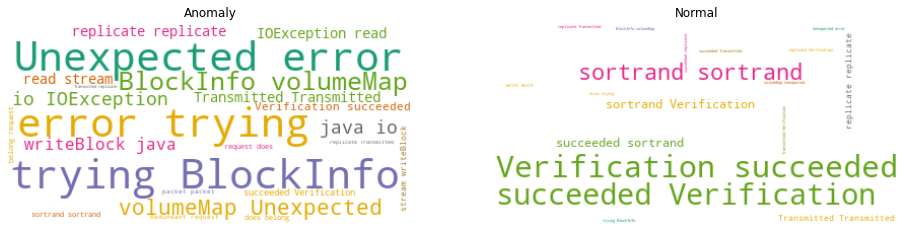

In [ ]:
# create subplot for Anomaly and normal

plt.rcParams['figure.figsize'] = [16,6]
Label=["Anomaly","Normal"]

for index, label in enumerate(data_t.columns):
  print(label)
  wc.generate(log_label.Content_npl[label])
  plt.subplot(1,2,index+1)
  plt.imshow(wc,interpolation='bilinear')
  plt.axis("off")
  plt.title(Label[index])
plt.show()

**Plot**

In [ ]:
import altair as alt

In [ ]:
df=data_t.sort_values(by=['Anomaly'], ascending=False)
df=df.reset_index()

In [ ]:
alt.Chart(df).mark_bar().encode(
    x=alt.X('index:O', sort='-y',axis=alt.Axis(title='Words')),
    y=alt.Y('Anomaly:Q'))

alt.Chart(...)

In [ ]:
alt.Chart(df).mark_bar().encode(
    x=alt.X('index:O', sort='-y',axis=alt.Axis(title='Words')),
    y=alt.Y('Normal:Q'))

alt.Chart(...)

# **Tentative Model Choices**

Supervised

- Random Forest
- Logistic Regression
- Nerual Network

Unsupervised
- PCA